## IPW vs Not AUROC Estimates

In [97]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os


### Read in probability of observing labels estimates

In [3]:
path = '/Users/conorcorbin/repos/er_infection/data/results/ast_models_c/yhats.csv'
df_p_labels = pd.read_csv(path)
df_p_labels.head()

,Unnamed: 0,anon_id,pat_enc_csn_id_coded,index_time,Cefazolin,Ceftriaxone,Cefepime,Zosyn,Vancomycin,Meropenem,Ampicillin,Ciprofloxacin,Vancomycin_Cefepime,Vancomycin_Ceftriaxone,Vancomycin_Meropenem,Vancomycin_Zosyn,label_unobserved,label,predictions
0,0,JCe8c709,131260660815,2019-01-01 03:27:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.381
1,1,JC2a0f1df,131260689128,2019-01-05 11:47:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.381
2,2,JCe7730f,131260730304,2019-01-05 00:27:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.449
3,3,JCe81fb3,131260740716,2019-01-07 06:42:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.369
4,4,JCcc70f0,131260768842,2019-01-03 20:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.446


### Calibrate Predictions (Isotonic)

In [7]:
class IdentityEstimator(LogisticRegression):
    def __init__(self):
        LogisticRegression.__init__(self)
            
    def predict_proba(self, input_array):   
        return input_array*1

    def decision_function(self, input_array):
        return input_array*1

def calibrate_probabilities(predictions, labels):
    """ 
    Takes in test set probabilites and does a k-fold cross fitting procedure to recalibrate each model
    """
    est = IdentityEstimator()
    X = predictions.values.reshape(-1, 1)
    y = labels
    isotonic_calibrated_predictions = np.array([float(i) for i in range(len(y))])
    sigmoid_calibrated_predictions = np.array([float(i) for i in range(len(y))])

    # Fit base estimator
    est.fit(X, y) # because we've overloaded predict_proba and decision function this doesn't matter

    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv='prefit', method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv='prefit', method='sigmoid')

    cv = StratifiedKFold(n_splits=10)
    for train_inds, val_inds in cv.split(X, y):
        X_train, y_train = X[train_inds], y[train_inds]
        X_val, y_val = X[val_inds], y[val_inds]
        isotonic.fit(X_train, y_train)
        isotonic_predictions = isotonic.predict_proba(X_val)
        isotonic_calibrated_predictions[val_inds] = isotonic_predictions[:, 1]

        sigmoid.fit(X_train, y_train)
        sigmoid_predictions = sigmoid.predict_proba(X_val)
        sigmoid_calibrated_predictions[val_inds] = sigmoid_predictions[:, 1]

    
    return sigmoid_calibrated_predictions, isotonic_calibrated_predictions

s_preds, i_preds = calibrate_probabilities(df_p_labels['predictions'], df_p_labels['label'])
df_p_labels['s_preds'] = s_preds
df_p_labels['i_preds'] = i_preds

In [8]:
df_p_labels.head()

,Unnamed: 0,anon_id,pat_enc_csn_id_coded,index_time,Cefazolin,Ceftriaxone,Cefepime,Zosyn,Vancomycin,Meropenem,...,Ciprofloxacin,Vancomycin_Cefepime,Vancomycin_Ceftriaxone,Vancomycin_Meropenem,Vancomycin_Zosyn,label_unobserved,label,predictions,s_preds,i_preds
0,0,JCe8c709,131260660815,2019-01-01 03:27:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,0.381,0.378895,0.407960
1,1,JC2a0f1df,131260689128,2019-01-05 11:47:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,0.381,0.378895,0.407960
2,2,JCe7730f,131260730304,2019-01-05 00:27:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,0.449,0.497911,0.527559
3,3,JCe81fb3,131260740716,2019-01-07 06:42:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,0.369,0.358936,0.367742
4,4,JCcc70f0,131260768842,2019-01-03 20:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,0.446,0.492552,0.522059


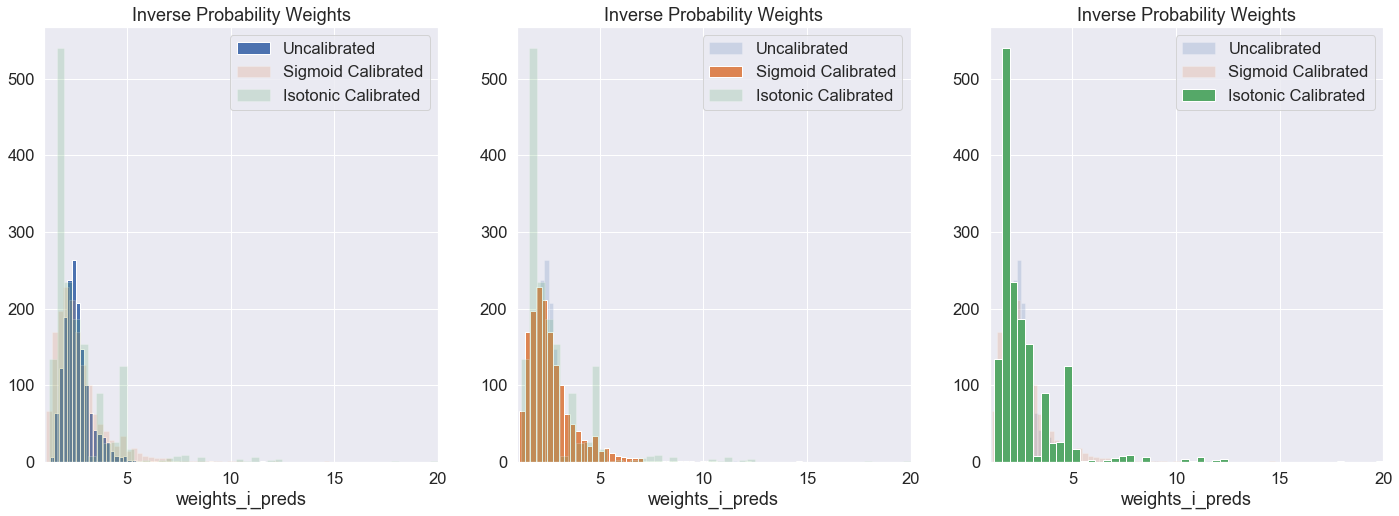

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

for i, preds in enumerate(['predictions', 's_preds' , 'i_preds']):
    # Clip and visualize weights 
    df_p_labels = (df_p_labels
        .assign(clipped_preds = lambda x: [0.05 if p < 0.05 else p for p in x[preds]])
    )
    df_p_labels['weights_%s' % preds] = [1./p for p in df_p_labels.clipped_preds]
    
    if preds == 'predictions': 
        lab = 'Uncalibrated'
    elif preds == 's_preds':
        lab = 'Sigmoid Calibrated'
    else:
        lab = 'Isotonic Calibrated'
    alpha = [0.1, 1.0, 0.1]
    for j in range(3):
        if j == 0:
            alpha = [1.0, 0.2, 0.2]
        elif j == 1:
            alpha = [0.2, 1.0, 0.2]
        else:
            alpha = [0.2, 0.2, 1.0]
        sns.set(font_scale=1.5)
        sns.distplot(df_p_labels[df_p_labels['label']==1]['weights_%s' % preds],
                     kde=False,
                     ax=ax[j],
                     label=lab,
                     hist_kws=dict(alpha=alpha[i]))
        ax[j].set_title("Inverse Probability Weights")
        ax[j].set_xlim([1, 20])
        ax[j].legend()

### Read in Coverage predictions

In [42]:
def load_predictions():
    """Helper function that loads predictions from AST classifiers for test set data"""
    
    base_path="/Users/conorcorbin/repos/er_infection/results/ast_models_w_not_infected/testing/{abx}"
    abx_options = ["Vancomycin",
                   "Ampicillin",
                   "Cefazolin",
                   "Ceftriaxone",
                   "Cefepime",
                   "Zosyn",
                   "Ciprofloxacin",
                   "Meropenem",
                   "Vancomycin_Meropenem",
                   "Vancomycin_Zosyn",
                   "Vancomycin_Cefepime",
                   "Vancomycin_Ceftriaxone"
                   ]
    df = pd.DataFrame()
    for i, abx in enumerate(abx_options):
        path = base_path.format(abx=abx)
        f_path = glob.glob(os.path.join(path, '*predictions.csv'))[0]
        if i == 0:
            df = pd.read_csv(f_path)
            df = df[['anon_id', 'pat_enc_csn_id_coded', 'label', 'predictions']]
            df = df.rename(columns={'label' : '%s_label' % abx,
                                    'predictions' : '%s_predictions' % abx})
        else:
            df_preds = pd.read_csv(f_path)
            df_preds = df_preds[['anon_id', 'pat_enc_csn_id_coded', 'label', 'predictions']]
            df_preds = df_preds.rename(columns={'label' : '%s_label' % abx,
                                                'predictions' : '%s_predictions' % abx})
            df = df.merge(df_preds, how='left', on=['anon_id', 'pat_enc_csn_id_coded'])
    
    return df
    
df = load_predictions()


In [43]:
df.head()

,anon_id,pat_enc_csn_id_coded,Vancomycin_label,Vancomycin_predictions,Ampicillin_label,Ampicillin_predictions,Cefazolin_label,Cefazolin_predictions,Ceftriaxone_label,Ceftriaxone_predictions,...,Meropenem_label,Meropenem_predictions,Vancomycin_Meropenem_label,Vancomycin_Meropenem_predictions,Vancomycin_Zosyn_label,Vancomycin_Zosyn_predictions,Vancomycin_Cefepime_label,Vancomycin_Cefepime_predictions,Vancomycin_Ceftriaxone_label,Vancomycin_Ceftriaxone_predictions
0,JC2a03b24,131260812263,0,0.218001,0,0.494820,0,0.720949,1,0.822168,...,1,0.919328,1,0.980916,1,0.966854,1,0.975707,1,0.914666
1,JCe45a3c,131260883970,1,0.431339,1,0.609399,0,0.701331,0,0.797252,...,0,0.883213,1,0.980916,1,0.956165,1,0.981404,1,0.925347
2,JCd235bb,131261001599,0,0.538608,0,0.537136,1,0.686221,1,0.805462,...,1,0.862787,1,0.981368,1,0.956677,1,0.964815,1,0.896064
3,JCd29af0,131261001696,0,0.461751,0,0.683057,0,0.578940,0,0.642049,...,1,0.556723,1,0.966940,1,0.946127,1,0.901523,0,0.891276
4,JCd356bf,131261014293,1,0.647562,1,0.660672,1,0.806878,1,0.789645,...,1,0.879717,1,0.976756,1,0.975514,1,0.935165,1,0.904496


In [52]:
df_final = (df
    .merge(df_p_labels, how='left', on='pat_enc_csn_id_coded')
)
abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]

# Compute AUROC for each antibiotic weighted by each of the three weights
aurocs = {}
aurocs['Antibiotic'] = []
aurocs['Unweighted'] = []
aurocs['Weighted Uncalibrated'] = []
aurocs['Weighted Sigmoid Calibrated'] = []
aurocs['Weighted Isotonic Calibrated'] = []
for abx in abx_options:
    aurocs['Antibiotic'].append(abx)
    predictions = df_final['%s_predictions' % abx]
    labels = df_final['%s_label' % abx]

    for w in ['unweighted', 'predictions', 's_preds' , 'i_preds']:
        if w != 'unweighted':
            weights = df_final[w]
        else:
            weights = [1.0 for i in range(len(df_final))]
        
        auroc = round(roc_auc_score(labels, predictions, sample_weight=weights), 2)
        if w == 'unweighted':
            aurocs['Unweighted'].append(auroc)
        elif w == 'predictions':
            aurocs['Weighted Uncalibrated'].append(auroc)
        elif w == 's_preds':
            aurocs['Weighted Sigmoid Calibrated'].append(auroc)
        else:
            aurocs['Weighted Isotonic Calibrated'].append(auroc)

df_results = pd.DataFrame(data=aurocs)
    

In [54]:
df_results

,Antibiotic,Unweighted,Weighted Uncalibrated,Weighted Sigmoid Calibrated,Weighted Isotonic Calibrated
0,Vancomycin,0.74,0.73,0.72,0.72
1,Ampicillin,0.69,0.69,0.69,0.69
2,Cefazolin,0.71,0.71,0.72,0.71
3,Ceftriaxone,0.72,0.72,0.73,0.73
4,Cefepime,0.64,0.65,0.65,0.65
5,Zosyn,0.65,0.67,0.68,0.68
6,Ciprofloxacin,0.64,0.65,0.66,0.65
7,Meropenem,0.71,0.71,0.71,0.71
8,Vancomycin_Meropenem,0.76,0.77,0.78,0.78
9,Vancomycin_Zosyn,0.71,0.71,0.71,0.71


In [92]:
import pdb
from tqdm import tqdm
def bootstrapped_performance(df, measure):
    """
    Given a performance measure, bootstraps test set examples and plots boxplots of said performance measure
    using each of the weighting scheme for each antibiotic label. 
    """
    df_results = pd.DataFrame()
    for i in tqdm(range(1000)):
        meas = {}
        meas['Antibiotic'] = []
        meas['Unweighted'] = []
        meas['Weighted Uncalibrated'] = []
        meas['Weighted Sigmoid Calibrated'] = []
        meas['Weighted Isotonic Calibrated'] = []
        
        df_sampled = (df
            .sample(n=len(df), replace=True)
        )
        for abx in abx_options:
            meas['Antibiotic'].append(abx)
            predictions = df_sampled['%s_predictions' % abx]
            labels = df_sampled['%s_label' % abx]

            for w in ['unweighted', 'predictions', 's_preds' , 'i_preds']:
                if w != 'unweighted':
                    weights = df_sampled[w]
                else:
                    weights = [1.0 for i in range(len(df_sampled))]

                m = measure(labels, predictions, sample_weight=weights)
                if w == 'unweighted':
                    meas['Unweighted'].append(m)
                elif w == 'predictions':
                    meas['Weighted Uncalibrated'].append(m)
                elif w == 's_preds':
                    meas['Weighted Sigmoid Calibrated'].append(m)
                else:
                    meas['Weighted Isotonic Calibrated'].append(m)

        df_meas = pd.DataFrame(data=meas)
        df_results = pd.concat([df_results, df_meas])
    df_results = (df_results
        .melt(id_vars=['Antibiotic'],
              value_vars=['Unweighted', 'Weighted Uncalibrated',
                          'Weighted Sigmoid Calibrated', 'Weighted Isotonic Calibrated'],
              var_name='Weighting',
              value_name='score')
        .reset_index()
    )
    return df_results
        

### Bootstrap AUROC

100%|██████████| 1000/1000 [01:05<00:00, 15.32it/s]


Text(0, 0.5, 'AUROC')

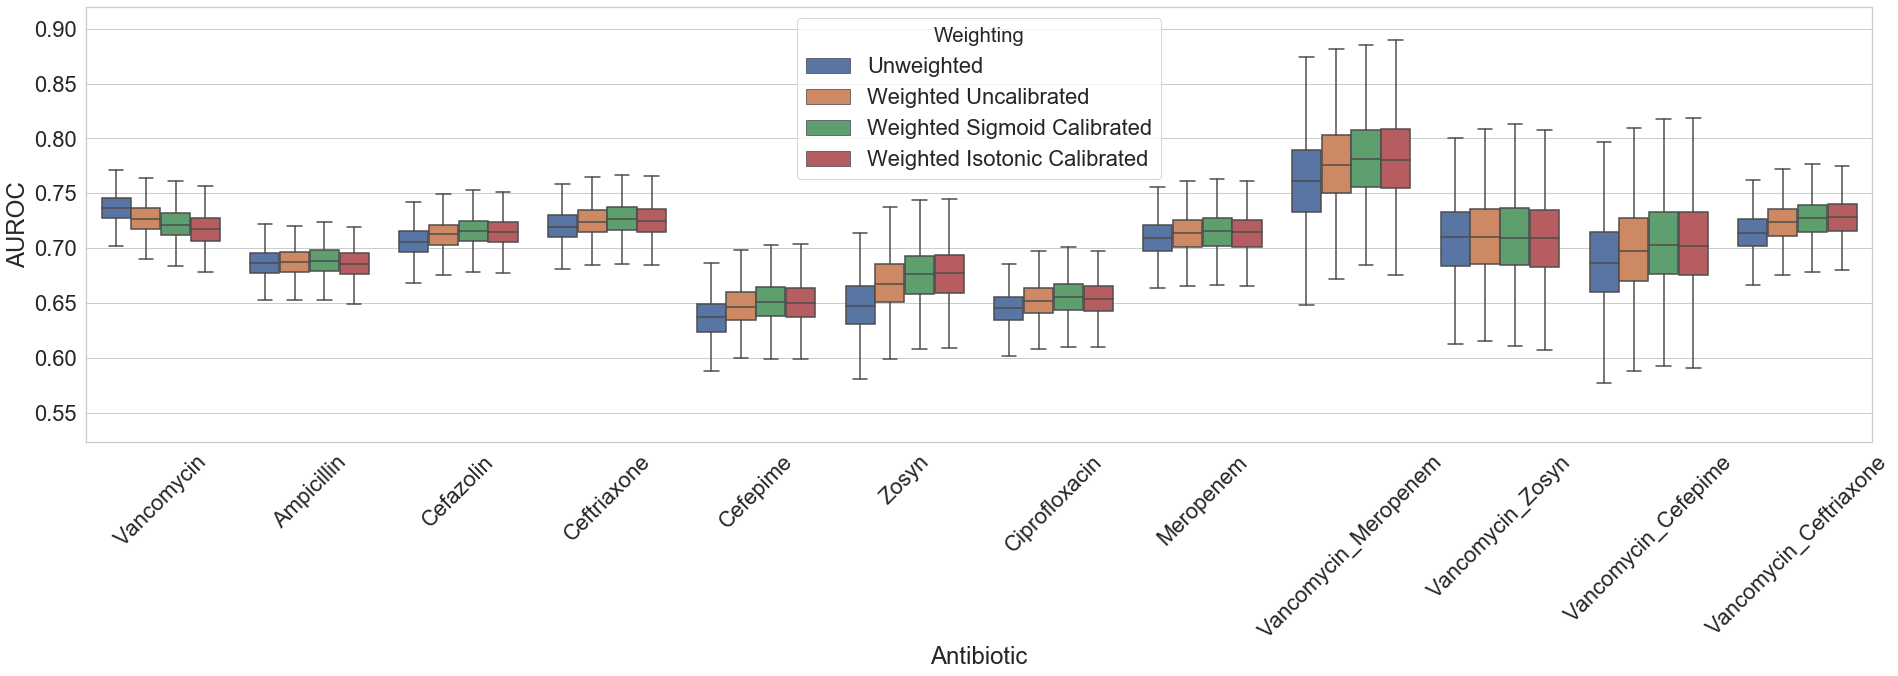

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(32, 8))
df_auroc = bootstrapped_performance(df_final, roc_auc_score)

sns.set(style='whitegrid', font_scale=2.0)
sns.boxplot(x='Antibiotic',
            y='score',
            hue='Weighting',
            data=df_auroc,
            fliersize=0
            )
plt.xticks(rotation = 45)
ax.set_ylabel('AUROC')

### Bootstrap Average Precision

100%|██████████| 1000/1000 [00:43<00:00, 23.20it/s]


Text(0, 0.5, 'Average Precision')

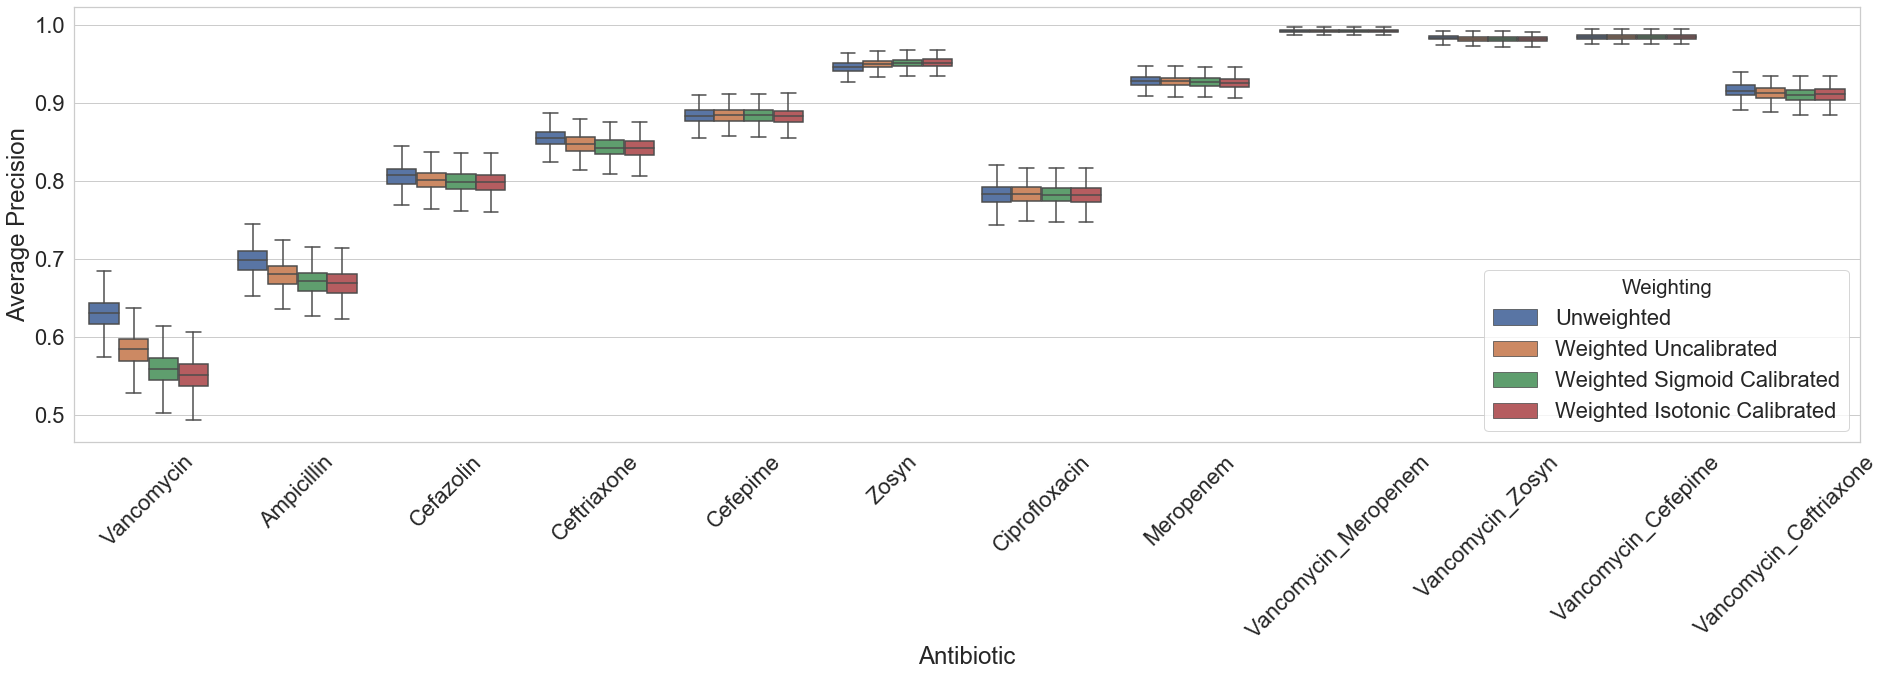

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(32, 8))
df_ap = bootstrapped_performance(df_final, average_precision_score)

sns.set(style='whitegrid', font_scale=2.0)
sns.boxplot(x='Antibiotic',
            y='score',
            hue='Weighting',
            data=df_ap,
            fliersize=0
            )
plt.xticks(rotation = 45)
ax.set_ylabel('Average Precision')

### Bootstrap Brier Score


100%|██████████| 1000/1000 [00:14<00:00, 69.75it/s]


Text(0, 0.5, 'Brier Score')

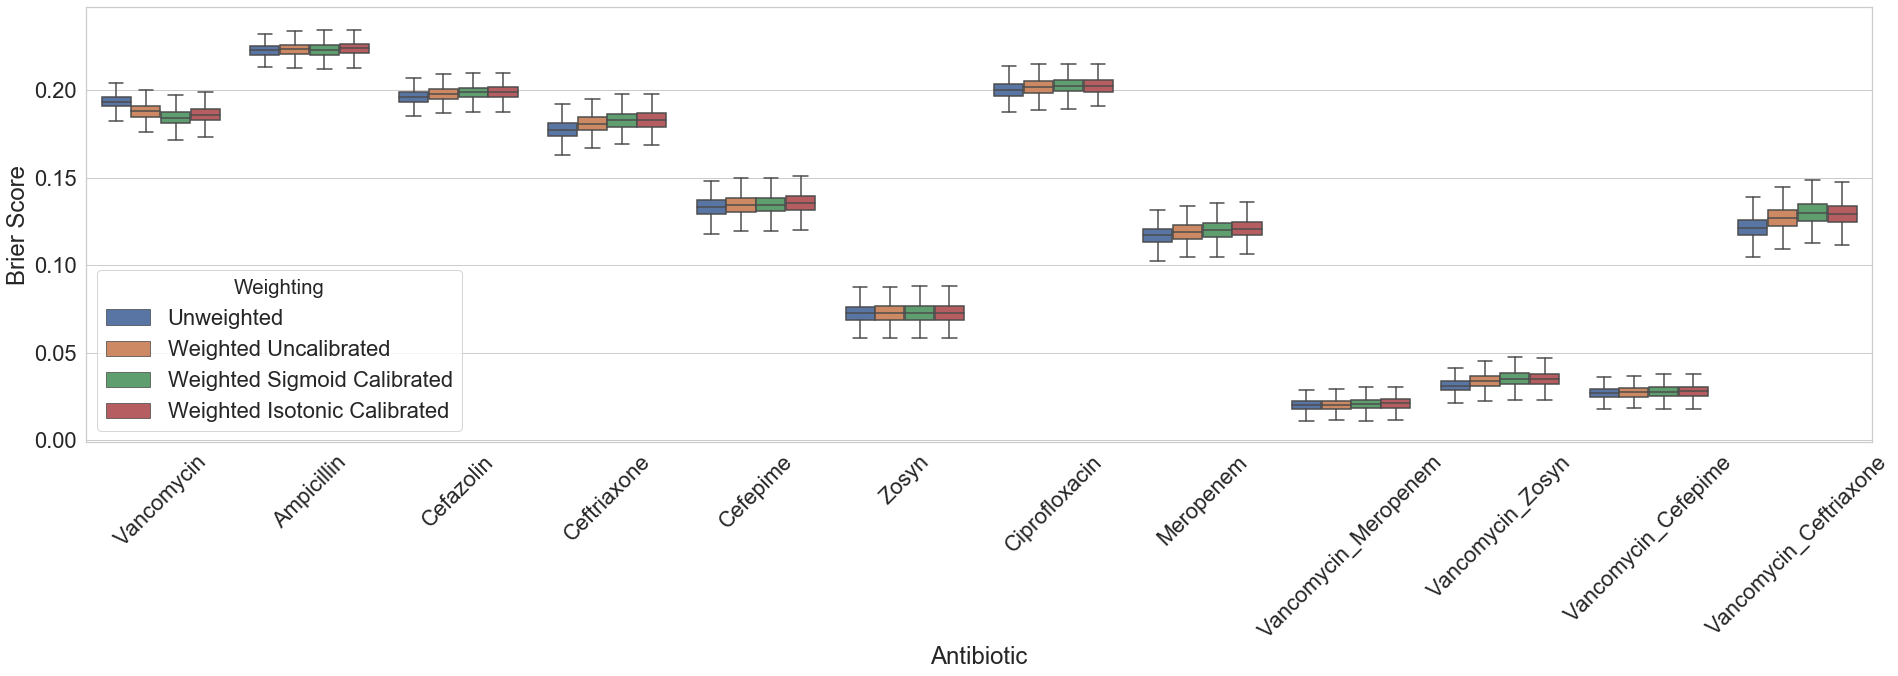

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(32, 8))
df_ap = bootstrapped_performance(df_final, brier_score_loss)

sns.set(style='whitegrid', font_scale=2.0)
sns.boxplot(x='Antibiotic',
            y='score',
            hue='Weighting',
            data=df_ap,
            fliersize=0
            )
plt.xticks(rotation = 45)
ax.set_ylabel('Brier Score')